In [1]:
import tensorflow as tf
import time

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)

In [2]:
import tarfile
import re
import urllib.request
import os
import random

class ImdbMovieReviews:
    DEFAULT_URL = \
        'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    TOKEN_REGEX = re.compile(r'[A-Za-z]+|[!?.:,()]')
    
    def __init__(self):
        self._cache_dir = './imdb'
        self._url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
        
        if not os.path.isfile(self._cache_dir):
            urllib.request.urlretrieve(self._url, self._cache_dir)
        self.filepath = self._cache_dir

    def __iter__(self):
        with tarfile.open(self.filepath) as archive:
            items = archive.getnames()
            for filename in archive.getnames():
                if filename.startswith('aclImdb/train/pos/'):
                    yield self._read(archive, filename), True
                elif filename.startswith('aclImdb/train/neg/'):
                    yield self._read(archive, filename), False
                    
    def _read(self, archive, filename):
        with archive.extractfile(filename) as file_:
            data = file_.read().decode('utf-8')
            data = type(self).TOKEN_REGEX.findall(data)
            data = [x.lower() for x in data]
            return data

In [3]:
import numpy as np
# Spacy is my favourite nlp framework, which havu builtin word embeddings trains on wikipesia
# from spacy.en import English
import spacy

class Embedding:
    
    def __init__(self):
#          spaCy makes using word vectors very easy. 
#             The Lexeme , Token , Span  and Doc  classes all have a .vector property,
#             which is a 1-dimensional numpy array of 32-bit floats:
#         self.parser = English()
#         self.parser = spacy.load('en')
        self.parser = spacy.load('en_vectors_web_lg')
#         self._length = length
        self.dimensions = 300
        
    def __call__(self, sequence, length):
        # DO I really need them to be equal length?
        # Let's assume I'm not
        data = np.zeros((length, self.dimensions))
        # you can access known words from the parser's vocabulary
        embedded = [self.parser.vocab[w].vector for w in sequence]
        data[:len(sequence)] = embedded
        return data

In [4]:
import itertools

def preprocess_batched_split(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch = []
        labelss = []
        sentence_sizes_batch = []
        for index in range(batch_size):
            text, label = next(iterator)
            sents = [list(y) for x, y in itertools.groupby(text, lambda z: z == '.') if not x]
            sentence_sizes = [len(s) for s in sents]
            text_embed = [embedding(sent) for sent in sents]
            
            batch.append(text_embed)
            labelss.append(label)
            sentence_sizes_batch.append(sentence_sizes)
            
        labels_batch = np.array(labelss, dtype=np.int32)
        sent_per_doc = np.array([len(x) for x in sentence_sizes_batch])
        words_per_sent_per_doc = np.array(sentence_sizes_batch)
        yield np.array(batch), labels_batch, words_per_sent_per_doc, sent_per_doc

In [5]:
import itertools

def preprocess_batched_split2(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch, labels_b = zip(*itertools.islice(iterator, batch_size))
        
        sents_b = [[list(y) for x, y in itertools.groupby(doc, lambda z: z == '.') if not x] for doc in batch]

        sentence_sizes_b = [[len(sent) for sent in doc] for doc in sents_b]
        sentence_size = max(map(max, sentence_sizes_b))
        
        document_sizes = np.array([len(doc) for doc in sentence_sizes_b], dtype=np.int32)
        document_size = document_sizes.max()

        sentence_sizes_np = np.zeros(shape=[batch_size, document_size], dtype=np.int32)
        for bi, ds, ss in zip(range(sentence_sizes_np.shape[0]), document_sizes, sentence_sizes_b):
            sentence_sizes_np[bi][:ds] = ss
        
        text_embed_b = np.zeros((batch_size, document_size, sentence_size, 300))
        for i, ds, doc_sents in zip(range(text_embed_b.shape[0]), document_sizes, sents_b):
            doc_sents_embed = np.array([embedding(sent, sentence_size) for sent in doc_sents])
            text_embed_b[i][:ds] = doc_sents_embed
        
        yield text_embed_b, np.array(labels_b, dtype=np.int32), np.array(document_sizes), sentence_sizes_np, sents_b

In [6]:
reviews = list(ImdbMovieReviews())

In [7]:
random.shuffle(reviews)

In [8]:
#################################################

In [9]:
%load_ext autoreload
%autoreload 1
%aimport HanSequenceLabellingModel, model_components
%aimport

Modules to reload:
HanSequenceLabellingModel model_components

Modules to skip:



In [10]:
batches_split = preprocess_batched_split2(reviews, Embedding(), batch_size=10)

In [11]:
from HanSequenceLabellingModel import HanSequenceLabellingModel

In [12]:
def HAN_model_1(session, restore_only=False):
    """Hierarhical Attention Network"""
    import tensorflow as tf
    try:
        from tensorflow.contrib.rnn import GRUCell, MultiRNNCell, DropoutWrapper
    except ImportError:
        MultiRNNCell = tf.nn.rnn_cell.MultiRNNCell
        GRUCell = tf.nn.rnn_cell.GRUCell
    from bn_lstm import BNLSTMCell
    from HanSequenceLabellingModel import HanSequenceLabellingModel

    is_training = tf.placeholder(dtype=tf.bool, name='is_training')

    cell = BNLSTMCell(80, is_training) # h-h batchnorm LSTMCell
    cell = MultiRNNCell([cell]*5)

    model = HanSequenceLabellingModel(
            embedding_size=300,
            classes=2,
            word_cell=cell,
            sentence_cell=cell,
            word_output_size=300,
            sentence_output_size=300,
            learning_rate=0.001,
            max_grad_norm=5.0,
            dropout_keep_proba=0.5,
            is_training=is_training,
    )

    saver = tf.train.Saver(tf.global_variables())
    checkpoint_dir = 'checkpoints'
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint:
        print("Reading model parameters from %s" % checkpoint.model_checkpoint_path)
        saver.restore(session, checkpoint.model_checkpoint_path)
    elif restore_only:
        raise FileNotFoundError("Cannot restore model")
    else:
        print("Created model with fresh parameters")
        session.run(tf.global_variables_initializer())
        
    return model, saver

In [ ]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())

    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc,) in enumerate(batches_split):

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        t0 = time.clock()
        step, summaries, loss, accuracy, _ = s.run([
                model.global_step,
                model.summary,
                model.loss,
                model.accuracy,
                model.train_op,
        ], feed_dict=fd)
        td = time.clock() - t0

        summary_writer.add_summary(summaries, global_step=step)

        checkpoint_frequency = 100
        eval_frequency = 1
        
        if step % 1 == 0:
            print('step %s, loss=%s, accuracy=%s, t=%s, inputs=%s' % (step, loss, accuracy, round(td, 2), fd[model.inputs_embedded].shape))
        if step != 0 and step % checkpoint_frequency == 0:
            print('checkpoint & graph meta')
            checkpoint_path = 'checkpoints/checkpoint'
            saver.save(s, checkpoint_path, global_step=step)
            print('checkpoint done')

Created model with fresh parameters
step 1, loss=0.738725, accuracy=0.2, t=10.37, inputs=(10, 14, 73, 300)
step 2, loss=0.680109, accuracy=0.8, t=8.25, inputs=(10, 29, 68, 300)
step 3, loss=0.714105, accuracy=0.6, t=10.36, inputs=(10, 23, 99, 300)
step 4, loss=0.698463, accuracy=0.5, t=6.24, inputs=(10, 16, 60, 300)
step 5, loss=0.68224, accuracy=0.6, t=11.46, inputs=(10, 24, 109, 300)
step 6, loss=0.700114, accuracy=0.2, t=9.41, inputs=(10, 35, 71, 300)
step 7, loss=0.674425, accuracy=0.5, t=13.91, inputs=(10, 53, 106, 300)
step 8, loss=0.661985, accuracy=0.8, t=8.66, inputs=(10, 38, 63, 300)
step 9, loss=0.725445, accuracy=0.4, t=7.17, inputs=(10, 38, 45, 300)
step 10, loss=0.70498, accuracy=0.5, t=12.06, inputs=(10, 35, 107, 300)
step 11, loss=0.736788, accuracy=0.1, t=21.29, inputs=(10, 14, 234, 300)
step 12, loss=0.692447, accuracy=0.6, t=13.15, inputs=(10, 32, 124, 300)
step 13, loss=0.718758, accuracy=0.4, t=8.04, inputs=(10, 14, 81, 300)
step 14, loss=0.697673, accuracy=0.5, t=

step 115, loss=0.585489, accuracy=0.8, t=7.19, inputs=(10, 24, 60, 300)
step 116, loss=0.706951, accuracy=0.5, t=13.94, inputs=(10, 45, 116, 300)
step 117, loss=0.544128, accuracy=0.6, t=18.22, inputs=(10, 18, 200, 300)
step 118, loss=0.578999, accuracy=0.7, t=11.21, inputs=(10, 38, 92, 300)
step 119, loss=0.645401, accuracy=0.6, t=9.79, inputs=(10, 39, 74, 300)
step 120, loss=0.707691, accuracy=0.4, t=7.6, inputs=(10, 31, 60, 300)
step 121, loss=0.736745, accuracy=0.6, t=6.78, inputs=(10, 20, 63, 300)
step 122, loss=0.631888, accuracy=0.7, t=8.76, inputs=(10, 22, 74, 300)
step 123, loss=0.658126, accuracy=0.6, t=9.22, inputs=(10, 20, 85, 300)
step 124, loss=0.64567, accuracy=0.6, t=12.89, inputs=(10, 20, 126, 300)
step 125, loss=0.598127, accuracy=0.8, t=7.64, inputs=(10, 34, 57, 300)
step 126, loss=0.740697, accuracy=0.7, t=6.69, inputs=(10, 17, 63, 300)
step 127, loss=1.05066, accuracy=0.3, t=7.38, inputs=(10, 17, 72, 300)
step 128, loss=0.667948, accuracy=0.7, t=9.8, inputs=(10, 44

step 228, loss=0.500318, accuracy=0.8, t=12.08, inputs=(10, 48, 89, 300)
step 229, loss=0.507281, accuracy=0.6, t=7.44, inputs=(10, 26, 64, 300)
step 230, loss=0.693437, accuracy=0.7, t=25.97, inputs=(10, 19, 291, 300)
step 231, loss=0.726843, accuracy=0.5, t=7.31, inputs=(10, 19, 68, 300)
step 232, loss=0.776327, accuracy=0.6, t=18.51, inputs=(10, 36, 184, 300)
step 233, loss=0.560051, accuracy=0.7, t=19.72, inputs=(10, 35, 197, 300)
step 234, loss=0.433054, accuracy=0.9, t=14.48, inputs=(10, 31, 143, 300)
step 235, loss=0.483411, accuracy=0.8, t=9.37, inputs=(10, 31, 79, 300)
step 236, loss=0.590708, accuracy=0.6, t=8.38, inputs=(10, 20, 81, 300)
step 237, loss=0.287642, accuracy=1.0, t=6.71, inputs=(10, 21, 63, 300)
step 238, loss=0.487943, accuracy=0.7, t=18.14, inputs=(10, 20, 198, 300)
step 239, loss=0.692253, accuracy=0.6, t=11.7, inputs=(10, 17, 127, 300)
step 240, loss=0.857229, accuracy=0.4, t=14.01, inputs=(10, 28, 139, 300)
step 241, loss=0.762325, accuracy=0.7, t=6.47, inp

step 341, loss=0.528729, accuracy=0.7, t=7.89, inputs=(10, 12, 84, 300)
step 342, loss=0.399829, accuracy=0.8, t=10.03, inputs=(10, 34, 85, 300)
step 343, loss=0.601686, accuracy=0.7, t=6.31, inputs=(10, 20, 54, 300)
step 344, loss=0.785623, accuracy=0.5, t=8.61, inputs=(10, 43, 64, 300)
step 345, loss=0.647831, accuracy=0.5, t=7.92, inputs=(10, 34, 61, 300)
step 346, loss=0.612553, accuracy=0.6, t=14.84, inputs=(10, 37, 125, 300)
step 347, loss=0.261351, accuracy=1.0, t=7.59, inputs=(10, 20, 63, 300)
step 348, loss=0.346268, accuracy=0.8, t=6.48, inputs=(10, 23, 51, 300)
step 349, loss=0.473015, accuracy=0.7, t=7.33, inputs=(10, 30, 52, 300)
step 350, loss=0.663025, accuracy=0.5, t=9.95, inputs=(10, 30, 77, 300)
step 351, loss=0.305707, accuracy=0.9, t=8.79, inputs=(10, 35, 60, 300)
step 352, loss=0.382447, accuracy=0.8, t=12.3, inputs=(10, 50, 87, 300)
step 353, loss=0.408819, accuracy=0.8, t=10.35, inputs=(10, 17, 96, 300)
step 354, loss=0.379801, accuracy=0.9, t=10.3, inputs=(10, 2

step 454, loss=0.48076, accuracy=0.8, t=9.53, inputs=(10, 27, 84, 300)
step 455, loss=0.206608, accuracy=1.0, t=10.75, inputs=(10, 36, 90, 300)
step 456, loss=0.527469, accuracy=0.8, t=11.46, inputs=(10, 30, 103, 300)
step 457, loss=0.303274, accuracy=0.9, t=6.56, inputs=(10, 19, 60, 300)
step 458, loss=0.74917, accuracy=0.8, t=6.89, inputs=(10, 13, 68, 300)
step 459, loss=0.606303, accuracy=0.8, t=7.02, inputs=(10, 30, 53, 300)
step 460, loss=0.524711, accuracy=0.8, t=9.38, inputs=(10, 23, 84, 300)
step 461, loss=0.954479, accuracy=0.7, t=9.28, inputs=(10, 35, 77, 300)
step 462, loss=0.196013, accuracy=1.0, t=7.41, inputs=(10, 20, 66, 300)
step 463, loss=0.325068, accuracy=0.8, t=5.33, inputs=(10, 18, 46, 300)
step 464, loss=0.241829, accuracy=1.0, t=10.72, inputs=(10, 16, 112, 300)
step 465, loss=0.496429, accuracy=0.8, t=12.65, inputs=(10, 42, 103, 300)
step 466, loss=0.301117, accuracy=0.8, t=9.04, inputs=(10, 28, 77, 300)
step 467, loss=0.211657, accuracy=0.9, t=6.63, inputs=(10, 

step 567, loss=0.501815, accuracy=0.8, t=30.25, inputs=(10, 15, 319, 300)
step 568, loss=0.42863, accuracy=0.7, t=13.59, inputs=(10, 27, 121, 300)
step 569, loss=0.392818, accuracy=0.8, t=12.87, inputs=(10, 30, 111, 300)
step 570, loss=0.309755, accuracy=0.8, t=14.51, inputs=(10, 48, 109, 300)
step 571, loss=0.495342, accuracy=0.7, t=11.26, inputs=(10, 54, 68, 300)
step 572, loss=1.15003, accuracy=0.5, t=15.02, inputs=(10, 41, 121, 300)
step 573, loss=0.371476, accuracy=0.8, t=6.16, inputs=(10, 25, 45, 300)
step 574, loss=0.298936, accuracy=0.9, t=12.09, inputs=(10, 12, 123, 300)
step 575, loss=0.66593, accuracy=0.8, t=10.47, inputs=(10, 40, 74, 300)
step 576, loss=0.889814, accuracy=0.6, t=10.8, inputs=(10, 18, 103, 300)
step 577, loss=0.325034, accuracy=0.9, t=11.28, inputs=(10, 23, 100, 300)
step 578, loss=0.670487, accuracy=0.6, t=9.72, inputs=(10, 19, 90, 300)
step 579, loss=0.276962, accuracy=0.8, t=8.79, inputs=(10, 25, 71, 300)
step 580, loss=0.379525, accuracy=0.7, t=8.02, inp

step 680, loss=0.423711, accuracy=0.7, t=7.65, inputs=(10, 20, 71, 300)
step 681, loss=0.632318, accuracy=0.6, t=12.46, inputs=(10, 18, 133, 300)
step 682, loss=0.421554, accuracy=0.9, t=8.68, inputs=(10, 34, 67, 300)
step 683, loss=0.760221, accuracy=0.7, t=9.65, inputs=(10, 38, 75, 300)
step 684, loss=0.334077, accuracy=0.7, t=8.28, inputs=(10, 33, 67, 300)
step 685, loss=0.302886, accuracy=0.8, t=7.51, inputs=(10, 18, 77, 300)
step 686, loss=0.349868, accuracy=0.8, t=12.44, inputs=(10, 35, 113, 300)
step 687, loss=0.188861, accuracy=1.0, t=22.71, inputs=(10, 15, 264, 300)
step 688, loss=0.705703, accuracy=0.5, t=9.45, inputs=(10, 32, 83, 300)
step 689, loss=0.358427, accuracy=0.8, t=7.54, inputs=(10, 11, 82, 300)
step 690, loss=0.289806, accuracy=0.9, t=10.28, inputs=(10, 41, 81, 300)
step 691, loss=0.36669, accuracy=0.7, t=13.89, inputs=(10, 26, 141, 300)
step 692, loss=0.411612, accuracy=0.9, t=9.19, inputs=(10, 22, 92, 300)
step 693, loss=0.632655, accuracy=0.8, t=11.44, inputs=(

step 793, loss=0.637363, accuracy=0.7, t=6.61, inputs=(10, 16, 65, 300)
step 794, loss=0.197624, accuracy=0.9, t=10.11, inputs=(10, 10, 107, 300)
step 795, loss=0.669643, accuracy=0.7, t=10.02, inputs=(10, 25, 98, 300)
step 796, loss=0.253424, accuracy=0.9, t=8.59, inputs=(10, 29, 78, 300)
step 797, loss=0.172169, accuracy=0.9, t=8.22, inputs=(10, 41, 59, 300)
step 798, loss=0.326026, accuracy=0.9, t=7.48, inputs=(10, 34, 58, 300)
step 799, loss=0.402025, accuracy=0.7, t=7.28, inputs=(10, 41, 48, 300)
step 800, loss=0.728362, accuracy=0.6, t=7.81, inputs=(10, 20, 76, 300)
checkpoint & graph meta
checkpoint done
step 801, loss=0.181754, accuracy=0.9, t=15.37, inputs=(10, 32, 151, 300)
step 802, loss=0.233407, accuracy=0.9, t=7.95, inputs=(10, 21, 78, 300)
step 803, loss=0.474612, accuracy=0.8, t=6.13, inputs=(10, 26, 50, 300)
step 804, loss=0.250413, accuracy=0.9, t=9.3, inputs=(10, 36, 74, 300)
step 805, loss=0.23952, accuracy=1.0, t=9.42, inputs=(10, 34, 76, 300)
step 806, loss=0.2785

step 906, loss=0.715759, accuracy=0.5, t=13.48, inputs=(10, 39, 120, 300)
step 907, loss=1.47006, accuracy=0.3, t=6.77, inputs=(10, 17, 67, 300)
step 908, loss=0.189893, accuracy=1.0, t=8.28, inputs=(10, 19, 82, 300)
step 909, loss=0.452692, accuracy=0.8, t=19.46, inputs=(10, 16, 218, 300)
step 910, loss=0.459181, accuracy=0.8, t=11.77, inputs=(10, 23, 115, 300)
step 911, loss=0.276422, accuracy=0.9, t=10.71, inputs=(10, 46, 84, 300)
step 912, loss=0.663066, accuracy=0.7, t=8.77, inputs=(10, 33, 71, 300)
step 913, loss=0.290237, accuracy=0.9, t=8.94, inputs=(10, 28, 78, 300)
step 914, loss=0.309446, accuracy=0.8, t=7.3, inputs=(10, 19, 66, 300)
step 915, loss=0.7042, accuracy=0.5, t=7.42, inputs=(10, 16, 74, 300)
step 916, loss=0.559466, accuracy=0.7, t=5.27, inputs=(10, 13, 52, 300)
step 917, loss=0.360195, accuracy=0.8, t=11.18, inputs=(10, 20, 116, 300)
step 918, loss=0.612429, accuracy=0.6, t=9.21, inputs=(10, 27, 83, 300)
step 919, loss=0.35477, accuracy=0.8, t=9.41, inputs=(10, 3

step 1019, loss=0.384719, accuracy=0.8, t=9.24, inputs=(10, 43, 66, 300)
step 1020, loss=0.302044, accuracy=0.9, t=7.51, inputs=(10, 27, 64, 300)
step 1021, loss=0.568095, accuracy=0.7, t=8.8, inputs=(10, 34, 73, 300)
step 1022, loss=0.301845, accuracy=0.8, t=10.11, inputs=(10, 30, 92, 300)
step 1023, loss=0.518177, accuracy=0.6, t=11.11, inputs=(10, 25, 102, 300)
step 1024, loss=0.280149, accuracy=0.8, t=7.19, inputs=(10, 20, 66, 300)
step 1025, loss=0.419453, accuracy=0.8, t=12.32, inputs=(10, 19, 132, 300)
step 1026, loss=0.237286, accuracy=0.9, t=10.03, inputs=(10, 41, 76, 300)
step 1027, loss=0.612793, accuracy=0.7, t=5.47, inputs=(10, 17, 48, 300)
step 1028, loss=0.329522, accuracy=0.9, t=23.71, inputs=(10, 16, 270, 300)
step 1029, loss=0.442658, accuracy=0.8, t=6.89, inputs=(10, 25, 56, 300)
step 1030, loss=0.2159, accuracy=0.9, t=12.72, inputs=(10, 21, 132, 300)
step 1031, loss=0.484399, accuracy=0.7, t=12.1, inputs=(10, 41, 99, 300)
step 1032, loss=0.537609, accuracy=0.8, t=7.

step 1130, loss=0.220299, accuracy=1.0, t=5.72, inputs=(10, 17, 54, 300)
step 1131, loss=0.232528, accuracy=0.9, t=8.75, inputs=(10, 26, 82, 300)
step 1132, loss=0.300236, accuracy=0.9, t=8.14, inputs=(10, 28, 68, 300)
step 1133, loss=0.304774, accuracy=0.9, t=12.95, inputs=(10, 45, 109, 300)
step 1134, loss=0.3779, accuracy=0.8, t=9.07, inputs=(10, 43, 61, 300)
step 1135, loss=0.445155, accuracy=0.9, t=8.26, inputs=(10, 16, 84, 300)
step 1136, loss=0.284841, accuracy=0.9, t=22.9, inputs=(10, 27, 251, 300)
step 1137, loss=0.369304, accuracy=0.9, t=5.87, inputs=(10, 13, 62, 300)
step 1138, loss=0.628122, accuracy=0.6, t=9.35, inputs=(10, 22, 93, 300)
step 1139, loss=0.239173, accuracy=0.9, t=8.31, inputs=(10, 14, 90, 300)
step 1140, loss=0.364129, accuracy=0.9, t=6.54, inputs=(10, 18, 63, 300)
step 1141, loss=0.138578, accuracy=1.0, t=11.79, inputs=(10, 19, 125, 300)
step 1142, loss=0.439469, accuracy=0.8, t=9.71, inputs=(10, 22, 95, 300)
step 1143, loss=0.814352, accuracy=0.7, t=8.49, 

step 1241, loss=0.447234, accuracy=0.8, t=7.54, inputs=(10, 22, 71, 300)
step 1242, loss=0.643986, accuracy=0.6, t=8.61, inputs=(10, 30, 71, 300)
step 1243, loss=0.384712, accuracy=0.8, t=7.06, inputs=(10, 20, 70, 300)
step 1244, loss=0.572842, accuracy=0.7, t=7.73, inputs=(10, 28, 65, 300)
step 1245, loss=0.431656, accuracy=0.7, t=14.02, inputs=(10, 31, 137, 300)
step 1246, loss=0.376786, accuracy=0.8, t=19.11, inputs=(10, 25, 203, 300)
step 1247, loss=0.667883, accuracy=0.7, t=7.4, inputs=(10, 19, 69, 300)
step 1248, loss=0.456201, accuracy=0.6, t=5.86, inputs=(10, 23, 50, 300)
step 1249, loss=0.370532, accuracy=0.8, t=6.52, inputs=(10, 23, 56, 300)
step 1250, loss=0.628372, accuracy=0.7, t=7.78, inputs=(10, 34, 61, 300)
step 1251, loss=0.590653, accuracy=0.8, t=5.08, inputs=(10, 10, 54, 300)
step 1252, loss=0.513292, accuracy=0.7, t=8.9, inputs=(10, 38, 71, 300)
step 1253, loss=0.690014, accuracy=0.7, t=7.13, inputs=(10, 17, 70, 300)
step 1254, loss=0.537719, accuracy=0.7, t=9.54, i

step 1352, loss=0.431776, accuracy=0.8, t=9.71, inputs=(10, 42, 71, 300)
step 1353, loss=0.277851, accuracy=0.8, t=14.49, inputs=(10, 21, 150, 300)
step 1354, loss=0.142872, accuracy=1.0, t=5.51, inputs=(10, 13, 57, 300)
step 1355, loss=0.203268, accuracy=0.9, t=8.45, inputs=(10, 13, 93, 300)
step 1356, loss=0.236133, accuracy=0.9, t=5.85, inputs=(10, 32, 42, 300)
step 1357, loss=0.399473, accuracy=0.8, t=5.91, inputs=(10, 19, 54, 300)
step 1358, loss=0.321787, accuracy=0.9, t=12.08, inputs=(10, 52, 91, 300)
step 1359, loss=0.331553, accuracy=0.9, t=9.41, inputs=(10, 45, 69, 300)
step 1360, loss=0.235143, accuracy=0.9, t=16.42, inputs=(10, 24, 173, 300)
step 1361, loss=0.63908, accuracy=0.7, t=8.87, inputs=(10, 22, 85, 300)
step 1362, loss=0.428152, accuracy=0.8, t=16.84, inputs=(10, 56, 146, 300)
step 1363, loss=0.612771, accuracy=0.6, t=8.77, inputs=(10, 27, 79, 300)
step 1364, loss=0.163914, accuracy=1.0, t=7.52, inputs=(10, 17, 80, 300)
step 1365, loss=0.717548, accuracy=0.6, t=12.

In [48]:
from colors import color

tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())
    
    data, labels_batch, sent_per_doc,\
    words_per_sent_per_doc, sents_batch = next(batches_split)

    fd = {
        model.is_training: True,
        model.inputs_embedded: data,
        model.word_lengths: words_per_sent_per_doc,
        model.sentence_lengths: sent_per_doc,
        model.labels: labels_batch,
        model.sample_weights: np.ones(shape=(10))
    }

    word_attentions, sent_attentions = s.run([model.word_attentions, 
                                              model.sent_attentions], 
                                             feed_dict=fd)
    
    sent_atts = sent_attentions[0]
    sents = sents_batch[0]
    
    max_sent_att = 0
    max_word_att = 0
    
    for sent_index in range(len(sents)):
        max_sent_att = max(max_sent_att, sent_atts[sent_index])
        
        for word_index in range(len(sents[sent_index])):
            max_word_att = max(max_word_att, word_attentions[sent_index][word_index])
    
    def print_with_color(text, main_color, intensity, ending=''):

        intense = int(255 * (1 - intensity))

        if main_color == 'red':
            back_color = '#ff{0:02X}{0:02X}'
        elif main_color == 'green':
            back_color = '#{0:02X}ff{0:02X}'
        elif main_color == 'blue':
            back_color = '#{0:02X}{0:02X}ff' 
        
        back_color = back_color.format(intense)
        
        print(color(text, fg='black', bg=back_color), end=ending)
    
    def draw_highlighted_att(max_sent_att_loc, max_word_att_loc):
        for sent_index in range(len(sents)):
            print_with_color('  ', 'red', sent_atts[sent_index] / max_sent_att_loc)

            for word_index in range(len(sents[sent_index])):
                print_with_color(sents[sent_index][word_index], 'blue', 
                                 word_attentions[sent_index][word_index] / max_word_att_loc, ' ')
            print()
    
    draw_highlighted_att(max_sent_att, max_word_att)
    print()
    draw_highlighted_att(1.0, 1.0)

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400


INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400


  a classic cartoon , always enjoyable and funny 
  it has an interesting plot complete with lovable characters 
  road rovers is a show worth seeing , it is a short episodes , and if you can ever manage a chance to see it , you should 
  unfortunately , it is very hard to find 
  i think warner brothers studios should release a dvd that contains all episodes 
  i would definitely buy it if they did , and if they do , you should buy it too 
  if you have kids who like dogs , they will love road rovers ! road rovers should have gotten more attention while it was being aired , it was definitely an original and very special show that should have been appreciated much more than it was 

  a classic cartoon , always enjoyable and funny 
  it has an interesting plot complete with lovable characters 
  road rovers is a show worth seeing , it is a short episodes , and if you can ever manage a chance to see it , you should 
  unfortunately , it is very hard to find 
  i think warner brothers st

In [13]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

goods_at_pos = []
goods_at_neg = []
bads_at_pos = []
bads_at_neg = []

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())
    
    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch) in enumerate(batches_split):

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        word_attentions, sent_attentions = s.run([model.word_attentions, 
                                                  model.sent_attentions], 
                                                 feed_dict=fd)

        def update(status, word, attention):
            def update_pos(word):
                goods_at_pos.append(attention[0]) if word == 'good' else bads_at_pos.append(attention[0])
            def update_neg(word):
                goods_at_neg.append(attention[0]) if word == 'good' else bads_at_neg.append(attention[0])

            update_pos(word) if status else update_neg(word)
        
        for review_index in range(len(sents_batch)):
            status = labels_batch[review_index]
            for sent_index in range(len(sents_batch[review_index])):
                for word_index in range(len(sents_batch[review_index][sent_index])):
                    word = sents_batch[review_index][sent_index][word_index]
                    if word == 'good' or word == 'bad':
                        attention = word_attentions[review_index * sent_attentions.shape[1]][word_index]
                        update(status, word, attention)
        
        print(i, end='\r')
        
        if i == 1000:
            break


Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400


In [17]:
import pickle

def serialize(name, cont):
    with open(name, 'wb') as handle:
        pickle.dump(cont, handle)
        
serialize('goods_at_pos.pickle', goods_at_pos)
serialize('goods_at_neg.pickle', goods_at_neg)
serialize('bads_at_pos.pickle', bads_at_pos)
serialize('bads_at_neg.pickle', bads_at_neg)

def deserialize(name):
    with open(name, 'rb') as handle:
        return pickle.load(handle)

In [18]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

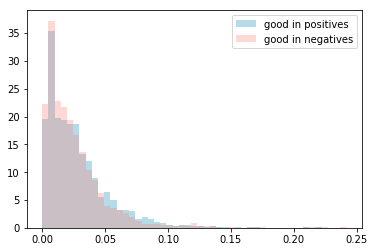

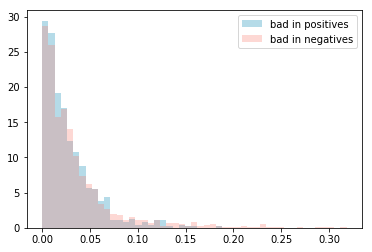

In [33]:
def draw_hist(pos, neg, word):
    max_att = max(max(pos), max(neg))
    
    bins = np.linspace(0, max_att, 50)   
    
    plt.hist(pos, bins=bins, color='lightblue', 
             alpha=0.9, label='{} in positives'.format(word), 
             normed=True)
    plt.hist(neg, bins=bins, color='salmon', 
             alpha=0.3, label='{} in negatives'.format(word),
             normed=True)
    
    plt.legend(loc='upper right')
    plt.show()

draw_hist(goods_at_pos, goods_at_neg, 'good')
draw_hist(bads_at_pos, bads_at_neg, 'bad')


attention weights for good is greater in positive reviews
attention weights for bad is greater in negative reviews

Everything is as expected

In [17]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

trues = 0
alls = 0

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())
    
    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch) in enumerate(batches_split):

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        preds = s.run(model.prediction, feed_dict=fd)
        
        corrects = (labels_batch == preds).sum()
        
        trues += corrects
        alls += len(labels_batch)
        
        print('at batch {} accuracy is {:.4f}'.format(i, trues / alls))
        
        if i == 100:
            break

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400
at batch 0 accuracy is 0.8000
at batch 1 accuracy is 0.9000
at batch 2 accuracy is 0.8667
at batch 3 accuracy is 0.9000
at batch 4 accuracy is 0.8400
at batch 5 accuracy is 0.8500
at batch 6 accuracy is 0.8571
at batch 7 accuracy is 0.8375
at batch 8 accuracy is 0.8444
at batch 9 accuracy is 0.8300
at batch 10 accuracy is 0.8364
at batch 11 accuracy is 0.8417
at batch 12 accuracy is 0.8462
at batch 13 accuracy is 0.8500
at batch 14 accuracy is 0.8467
at batch 15 accuracy is 0.8562
at batch 16 accuracy is 0.8647
at batch 17 accuracy is 0.8611
at batch 18 accuracy is 0.8579
at batch 19 accuracy is 0.8650
at batch 20 accuracy is 0.8571
at batch 21 accuracy is 0.8500
at batch 22 accuracy is 0.8478
at batch 23 accuracy is 0.8458
at batch 24 accuracy is 0.8520
at batch 25 accuracy is 0.8423
at batch 26 accuracy is 0.8407
at batch 27 accuracy is 0.8464
at batch 28 ac